In [2]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle, random
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    StableDiffusionControlNetInpaintPipeline,
    UniPCMultistepScheduler,
)
from torchvision import transforms
import cv2
from cv2 import seamlessClone
import albumentations as A
from PIL.Image import Resampling

/home/user01/software/miniconda3/envs/diffuser/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# utility functions
def get_moments(img):
    img = img.convert('L')
    img = np.array(img)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 使用 max 函数和一个简单的 lambda 函数，找到面积最大的连通区域
    max_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(max_contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cY, cX)

def switch_color(img1,img2):
    image = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)
    image2 = cv2.cvtColor(img2, cv2.COLOR_RGB2LAB)

    mean , std  = image.mean(axis=(0,1), keepdims=True), image.std(axis=(0,1), keepdims=True)
    mean2, std2 = image2.mean(axis=(0,1), keepdims=True), image2.std(axis=(0,1), keepdims=True)
    image = np.uint8(np.clip((image-mean)/std*std2+mean2, 0, 255))
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    return image

def update_bbox(bbox, x_ratio, y_ratio):
    bbox = np.array(bbox)
    bbox[0] = int(bbox[0] * x_ratio)
    bbox[1] = int(bbox[1] * y_ratio)
    bbox[2] = int(bbox[2] * x_ratio)
    bbox[3] = int(bbox[3] * y_ratio)
    return bbox

def calculate_masked_lab_mean(img, mask):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    mean_color = cv2.mean(img, mask=mask)[:3]
    return mean_color

def get_patch_mean(img, i, j, patch_size):
    patch = img[i:i+patch_size, j:j+patch_size]
    return np.mean(patch, axis=(0, 1))

def split_image_and_calculate_means(img, patch_size=32):
    h, w, _ = img.shape
    patch_means = []
    patch_centers = []
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    for i in range(patch_size * 2, h - patch_size * 2, patch_size):
        for j in range(patch_size * 2, w - patch_size * 2, patch_size):
            center_patch_mean = get_patch_mean(img, i, j, patch_size)
            top_patch_mean = get_patch_mean(img, i - patch_size, j, patch_size) if i - patch_size >= 0 else 0
            bottom_patch_mean = get_patch_mean(img, i + patch_size, j, patch_size) if i + patch_size < h else 0
            left_patch_mean = get_patch_mean(img, i, j - patch_size, patch_size) if j - patch_size >= 0 else 0
            right_patch_mean = get_patch_mean(img, i, j + patch_size, patch_size) if j + patch_size < w else 0
            
            # 计算五个区域的平均值
            total_mean = (center_patch_mean + top_patch_mean + bottom_patch_mean + left_patch_mean + right_patch_mean) / 5
            patch_centers.append((i + patch_size // 2, j + patch_size // 2))
            patch_means.append(total_mean)
    
    return patch_means, patch_centers

def find_nearest_patch_center(target_rgb, patch_rgbs, patch_centers):
    target_rgb = np.array(target_rgb)
    patch_rgbs = np.array(patch_rgbs)
    distances = np.linalg.norm(patch_rgbs-target_rgb, axis = 1)
    nearest_idx = np.argmin(distances)
    return patch_centers[nearest_idx]

def recenter_image(img, original_center, new_center):
    print(original_center, new_center)
    dy, dx = np.subtract(new_center, original_center)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    recentered_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return recentered_img

def get_bbox(mask):
    mask = np.array(mask).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    return [x, y, x+w, y+h]

def get_mask(mask, bbox):
    H, W = mask.shape
    extended_bbox=np.array(bbox)
    
    left_freespace=min(bbox[0]-0, 5)
    right_freespace=min(W-bbox[2],5)
    up_freespace=min(bbox[1]-0,5)
    down_freespace=min(H-bbox[3],5)
    
    extended_bbox[0]=bbox[0]-int(left_freespace)
    extended_bbox[1]=bbox[1]-int(up_freespace)
    extended_bbox[2]=bbox[2]+int(right_freespace)
    extended_bbox[3]=bbox[3]+int(down_freespace)
    
    bbox_mask = np.zeros_like(mask)
    bbox_mask[extended_bbox[1]:extended_bbox[3],extended_bbox[0]:extended_bbox[2]] = 1
    mask_img= mask*bbox_mask
    return mask_img

def get_crop(img, bbox):
    W, H = img.size
    extended_bbox=np.array(bbox)
    
    left_freespace=min(bbox[0]-0, 30)
    right_freespace=min(W-bbox[2],30)
    up_freespace=min(bbox[1]-0,30)
    down_freespace=min(H-bbox[3],30)
    
    extended_bbox[0]=bbox[0]-int(left_freespace)
    extended_bbox[1]=bbox[1]-int(up_freespace)
    extended_bbox[2]=bbox[2]+int(right_freespace)
    extended_bbox[3]=bbox[3]+int(down_freespace)
    
    return img.crop(extended_bbox)

def clone(original_image, source_images, mask, target_center, padding = 100):
    # padding the original image with 10 pixels, which is the image of the original image
    padding = padding
    new_image = cv2.copyMakeBorder(original_image, padding, padding, padding, padding, cv2.BORDER_REFLECT_101)
    target_center = (target_center[0] + padding, target_center[1] + padding)
    new_image = seamlessClone(source_images, new_image, np.where(np.array(mask)> 127,255 ,0).astype(np.uint8), (target_center[1], target_center[0]), flags=cv2.NORMAL_CLONE)
    new_image = new_image[padding:-padding, padding:-padding]
    
    return Image.fromarray(new_image)

def copy_paste(original_image, source_images, mask):
    mask = np.where(np.array(mask)> 127,1 ,0).astype(np.uint8)
    mask = mask[:,:,np.newaxis]
    output = original_image.copy()
    output = output*(1 - mask) + source_images*mask
    return Image.fromarray(output)

def random_size(control_image, source_images, mask, ratio = 0.5):
    # reduce the H,W up to 0.5
    ratio = random.uniform(ratio, 1.0)
    print(ratio)
    control_image = control_image.resize((int(512*ratio), int(512*ratio)), Resampling.BILINEAR)
    source_images = source_images.resize((int(512*ratio), int(512*ratio)), Resampling.BILINEAR)
    mask = mask.resize((int(512*ratio), int(512*ratio)), Resampling.BILINEAR)
    
    # padding in right and bottom
    padding = 512 - control_image.size[0]
    control_image = cv2.copyMakeBorder(np.array(control_image), 0, padding, 0, padding, cv2.BORDER_CONSTANT, value = 0)
    source_images = cv2.copyMakeBorder(np.array(source_images), 0, padding, 0, padding, cv2.BORDER_CONSTANT, value = 0)
    mask = cv2.copyMakeBorder(np.array(mask), 0, padding, 0, padding, cv2.BORDER_CONSTANT, value = 0)

    control_image = Image.fromarray(control_image)
    source_images = Image.fromarray(source_images)
    mask = Image.fromarray(mask)
    return control_image, source_images, mask
    
def load_data():
    # input_image = "/home/majiajian/temp/datasets/sun_negative/train"
    input_image = "/home/user01/majiajian/data/polyp/negatives"
    # input_image = "/home/majiajian/temp/datasets/ETIS-LaribPolypDB/images"
    input_image = os.path.join(input_image, random.choice(os.listdir(input_image)))

    imgs_path = "/home/user01/majiajian/data/polyp/SUN-SEG_10/TrainDataset_10/masks"
    source_image_path = "/home/user01/majiajian/data/polyp/SUN-SEG_10/TrainDataset_10/images"
    
    folders = os.listdir(imgs_path)
    folder = random.choice(folders)

    images = os.listdir(os.path.join(imgs_path, folder))
    source_images = os.listdir(os.path.join(source_image_path, folder))
    
    images.sort()
    source_images.sort()

    index = random.randint(0,len(images)-1)

    img_path = os.path.join(imgs_path, folder, images[index])
    source_images = os.path.join(source_image_path, folder, source_images[index])
    

    control_image = load_image(img_path).convert('RGB')

    mask = np.array(control_image.copy().convert('L'))
    bbox = get_bbox(mask)
    mask = get_mask(mask, bbox)
    control_image = Image.fromarray(np.array(mask).copy()).convert('RGB')
    
    mask = cv2.dilate(mask, np.ones((30,30), np.uint8), iterations=1)
    mask = Image.fromarray(mask)
    
    original_image = load_image(input_image)
    original_image = original_image.crop((0.05*original_image.size[0], 0.05*original_image.size[1], 0.95*original_image.size[0], 0.95*original_image.size[1]))

    source_images = load_image(source_images)
    
    
    mask = mask.resize((512, 512), Resampling.BILINEAR)
    control_image = control_image.resize((512, 512), Resampling.BILINEAR)
    original_image = original_image.resize((512, 512), Resampling.BILINEAR)
    
    
    # initial_mask removing the total black area
    initial_mask = (cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY) > 1).astype(np.uint8)
    
    transform = A.RandomBrightness(limit=(-0.1 , 0.1), p=0.5)
    seed = np.random.randint(0, 2 ** 32 - 1)
    random.seed(seed)
    np.random.seed(seed)
    original_image = transform(image=np.array(original_image))['image']
    original_image = Image.fromarray(original_image)
    
    random.seed(seed)
    np.random.seed(seed)
    source_images = transform(image=np.array(source_images))['image']
    source_images = Image.fromarray(source_images)

    bbox_source_images = get_crop(source_images, bbox)
    bbox_source_images = bbox_source_images.resize((512, 512), Resampling.BILINEAR)
    
    source_images = source_images.resize((512, 512), Resampling.BILINEAR)
    source_images_copy = source_images.copy()

    # source_images = Image.fromarray(switch_color(np.array(source_images), np.array(original_image)))
    # check the size of the mask > 0
    temp_size = np.sum(np.array(control_image.convert("L")) > 0)/ 512 / 512
    
    if temp_size > 0.2:
        control_image, source_images, mask = random_size(control_image, source_images, mask, ratio = 0.6)
    elif temp_size > 0.1:
        control_image, source_images, mask = random_size(control_image, source_images, mask, ratio = 0.75)
    elif temp_size > 0.05:
        control_image, source_images, mask = random_size(control_image, source_images, mask, ratio = 0.9)
        
    old_center = get_moments(control_image)
    
    

    mean_of_source_images = calculate_masked_lab_mean(np.array(source_images), np.where(np.array(mask)> 127,1 ,0).astype(np.uint8))
    original_mean, original_center = split_image_and_calculate_means(np.array(original_image))
    target_center = find_nearest_patch_center(mean_of_source_images, original_mean, original_center)
    
    # source_images = switch_color(np.array(source_images), np.array(original_image))
    
    source_images = recenter_image(np.array(source_images),old_center, target_center)
    mask = recenter_image(np.array(mask), old_center, target_center)
    control_image = recenter_image(np.array(control_image), old_center, target_center)
    control_image = control_image * initial_mask[:,:,np.newaxis]
    
    
    # new_image = clone(np.array(original_image), source_images, mask, target_center)
    new_image = copy_paste(np.array(original_image), source_images, control_image[:,:,0])
    if temp_size > 0.05:
        control_image = cv2.erode(np.array(control_image), np.ones((5,5), np.uint8), iterations=1)
    
    source_images = Image.fromarray(source_images)
    mask = Image.fromarray(mask)
    control_image = Image.fromarray(control_image)
    
    

    control_tensor = [control_image, bbox_source_images]
    
    return original_image, new_image, control_tensor, control_image, source_images_copy, mask, bbox


def visualization(original_image, control_image, mask, image, image_2, source_image, source_image_copy):
    fig, ax = plt.subplots(1, 7, figsize=(42, 10))
    ax[0].imshow(original_image)
    ax[1].imshow(control_image)
    ax[2].imshow(mask)
    ax[3].imshow(image)
    ax[4].imshow(image_2)
    ax[5].imshow(source_image)
    ax[6].imshow(source_image_copy)
    # close the axis
    for i in range(7):
        ax[i].axis('off')
    plt.show()

In [4]:

boundary_controlnet = "/home/user01/majiajian/code/diffusion/diffusers/output_model/multicontrolnet/checkpoint-16000/boundary_controlnet"
surface_controlnet = "/home/user01/majiajian/code/diffusion/diffusers/output_model/multicontrolnet/checkpoint-16000/surface_controlnet"
# checkpoint_3 = "/home/majiajian/temp/diffusers/examples/controlnet/models/polyp/inpaint_5e5_original"
stablediffusion_checkpoint = "/home/user01/majiajian/code/diffusion/diffusers/output_model/sd_inpaint/inpaint_1e5"

prompt = "an endoscopic image of a polyp"

controlnet_1 = ControlNetModel.from_pretrained(boundary_controlnet, torch_dtype=torch.float16)
controlnet_2 = ControlNetModel.from_pretrained(surface_controlnet, torch_dtype=torch.float16)
# controlnet_3 = ControlNetModel.from_pretrained(checkpoint_3, torch_dtype=torch.float16)

controlnet = [controlnet_1, controlnet_2]

pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    stablediffusion_checkpoint, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# pipe_2 = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     stablediffusion_checkpoint, controlnet=controlnet_3, torch_dtype=torch.float16, safety_checker=None
# )
# pipe_2.scheduler = UniPCMultistepScheduler.from_config(pipe_2.scheduler.config)
# pipe_2.to("cuda")

generator = torch.manual_seed(20)




Loading pipeline components...: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


(128, 366) (432, 368)
(128, 366) (432, 368)
(128, 366) (432, 368)
0.01433563232421875


100%|██████████| 27/27 [00:02<00:00, 11.25it/s]


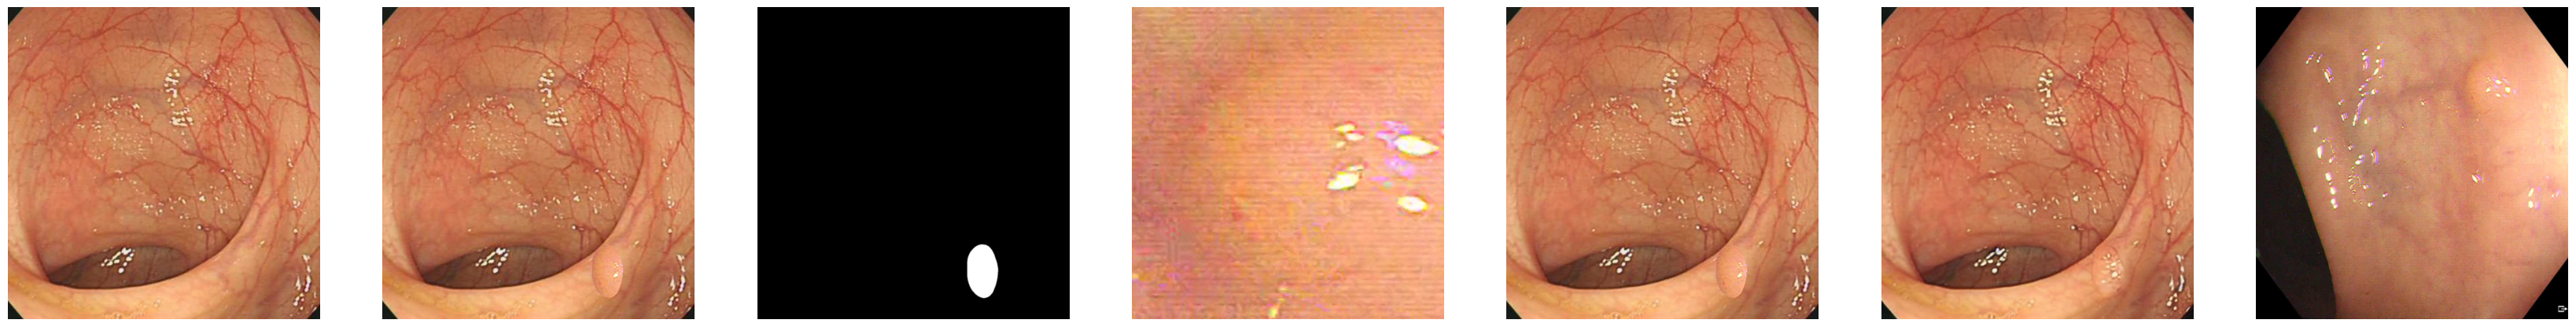

In [32]:
original_image, new_image, control_tensor, control_image, source_images, mask, bbox = load_data()

# get the size of the control_image
temp_size = np.sum(np.array(control_image.convert("L")) > 0)/ 512 / 512
print(temp_size)

if temp_size < 0.025:
    ref_image = new_image
else:
    ref_image = original_image

if temp_size > 0.03:
    strength = 0.9
elif temp_size > 0.02:
    strength = 0.85
elif temp_size > 0.015:
    strength = 0.7
elif temp_size > 0.01:
    strength = 0.55
else:
    strength = 0.5

image = pipe(prompt = prompt, num_inference_steps=50, generator=generator, image=ref_image, 
             mask_image = mask, control_image = control_tensor, strength = strength).images[0]

# image_2 = pipe_2(prompt = prompt, num_inference_steps=50, generator=generator, image=ref_image, 
#              mask_image = mask, control_image = control_tensor[0], strength = 0.85).images[0]

visualization(original_image, new_image, control_image, control_tensor[1], ref_image, image, source_images)

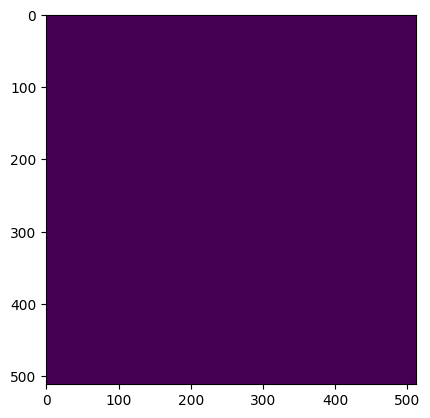

In [6]:
# get the gradient of the background image
background = np.array(original_image)
background = cv2.cvtColor(background, cv2.COLOR_RGB2GRAY)
magnitude = background>1
# grad_x = cv2.Sobel(background, cv2.CV_64F, 1, 0, ksize=3)
# grad_y = cv2.Sobel(background, cv2.CV_64F, 0, 1, ksize=3)
# magnitude = cv2.magnitude(grad_x, grad_y)
# magnitude = (magnitude>0).astype(np.uint8)
magnitude = cv2.morphologyEx(magnitude.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
plt.imshow(magnitude)
plt.show()

In [7]:
# from diffusers import DDPMScheduler
# import torchvision.transforms as T
# import torch

# noise_scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# vae = pipe.vae
# transforms = T.Compose(
#     [
#         T.ToTensor(),
#         T.Normalize(mean=0.5, std=0.5),
#     ]
# )
# original_image_new = transforms(new_image)
# original_image_new = original_image_new.unsqueeze(0).cuda()
# original_image_new = original_image_new.to(torch.float16)
# latents = vae.encode(original_image_new).latent_dist.sample()
# latents = latents * vae.config.scaling_factor
# noise = torch.randn_like(latents).to(latents.device).to(latents.dtype)
# timesteps = torch.randint(450,  500, (1,), device=latents.device)
# timesteps = timesteps.long()
# noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
# noisy_latents = noisy_latents / vae.config.scaling_factor
# noisy_images = vae.decode(noisy_latents).sample
# noisy_images = ((noisy_images +1) / 2.0).clamp(0, 1)
# noisy_images = 255. * (noisy_images.detach().cpu().numpy())
# noisy_images = np.transpose(noisy_images, (0, 2, 3, 1))
# plt.imshow(noisy_images[0].astype(np.uint8))
# plt.show()
